### House Prices Prediction using pyTorch


In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')


In [ ]:
# Sort column names alphabetically and print them
sorted_columns = sorted(train_data.columns)
for column in sorted_columns:
    print(column)


In [ ]:
train_data.info()

In [ ]:
train_data.drop(columns=["Alley"], inplace=True)

In [ ]:
for object in train_data['MasVnrType'].unique():
    print(object)

In [ ]:
train_data.info()

In [3]:
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['SalePrice'], axis=1).copy()
y = train_data['SalePrice'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = X_train.join(y_train)
val_data = X_val.join(y_val)


In [ ]:
val_data.info()

In [ ]:
train_data.info()

In [ ]:
sns.histplot(train_data['SalePrice'], bins=100, kde = True, linewidth=0)
plt.xlabel('Sale Price')

In [ ]:
train_data.head(3)

In [ ]:
sns.displot(train_data['SalePrice'], color ='g', alpha = 0.4, bins = 100, kde= True, binwidth=10000) 


In [4]:
numerical_values = train_data.select_dtypes(include=[np.number])

In [5]:
numerical_values = numerical_values.drop(columns=["Id"], errors="ignore")

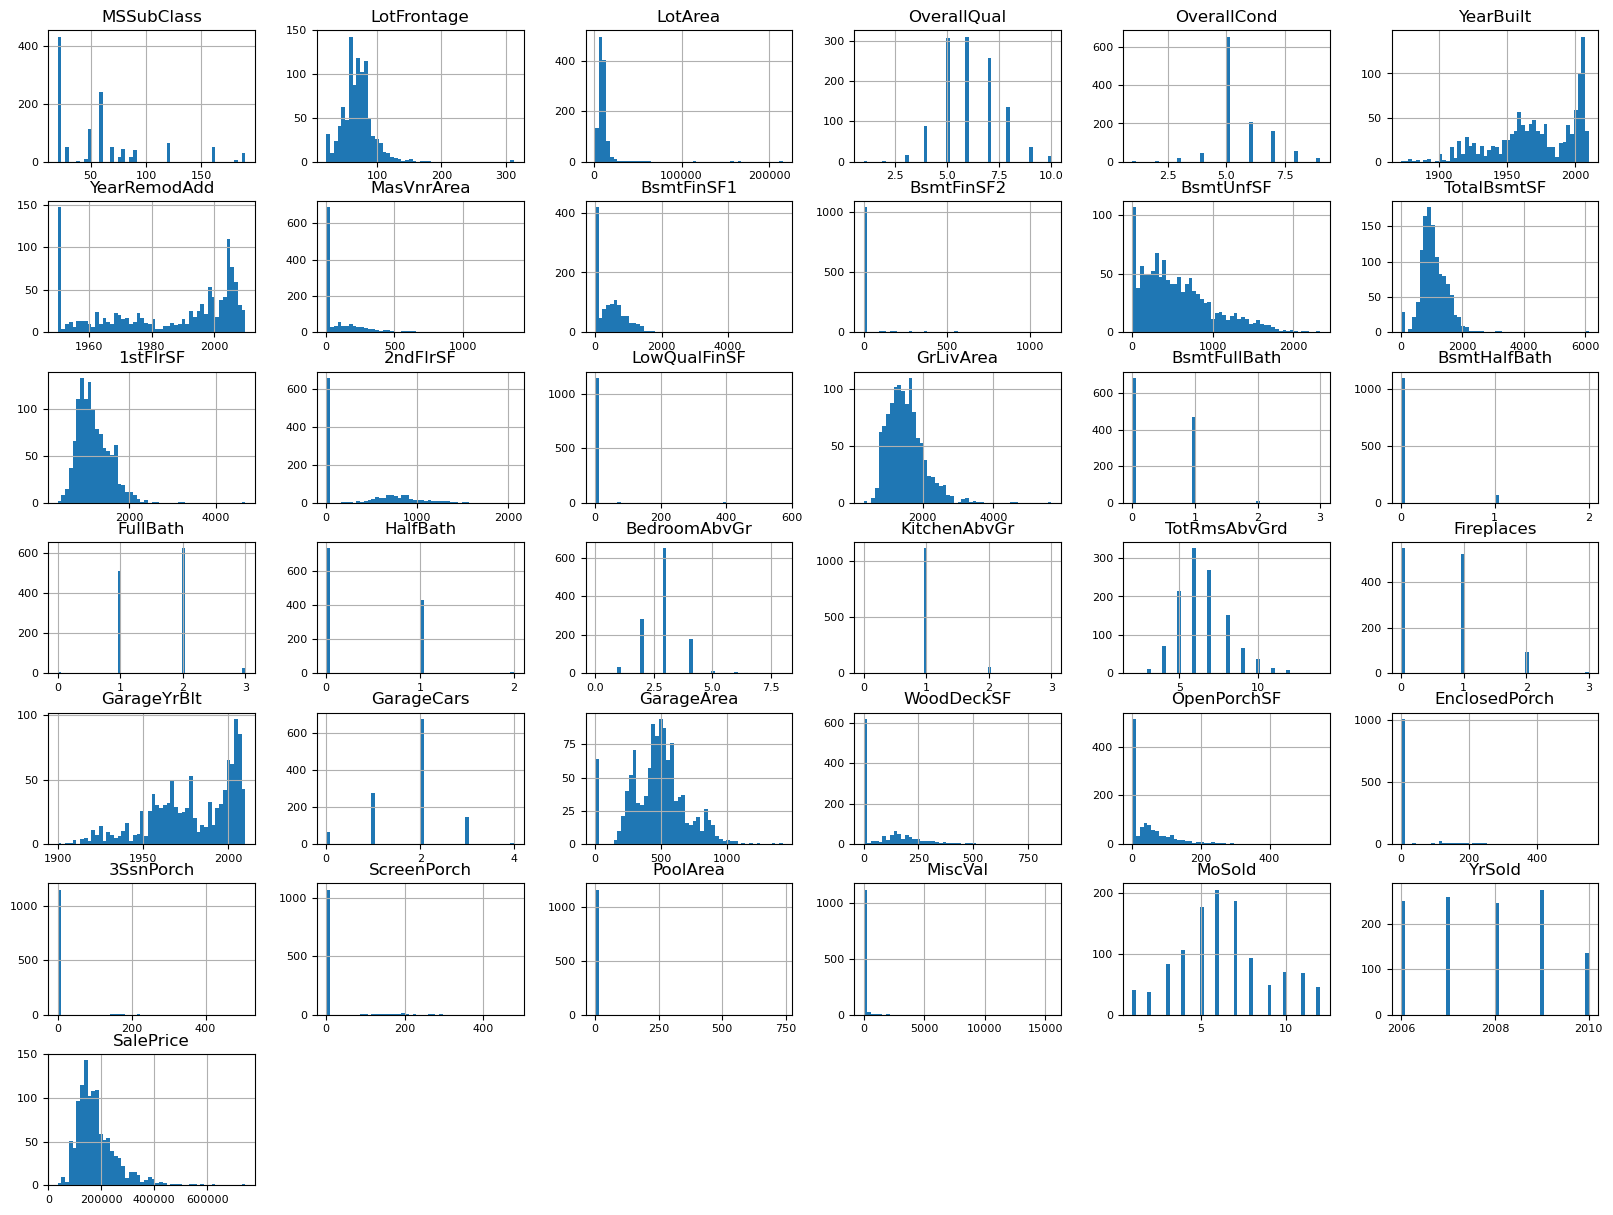

In [6]:
numerical_values.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()  

In [ ]:
numerical_values.info() 

### Feature Engineering and Data Visualization (Pipeline)

Since features like LotArea, GrLivArea, SalePrice, TotalBsmtSF, 1stFlrSF are highly right-skewed, we will pply log1p transform (np.log1p(x)) to reduce skewness and make distribution more Gaussian-like.

This should improve model performance, especially for linear models and some tree-based ones.

We will then find outliers using Z-score method and remove them from the dataset.



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_prop = 0.05, columns =["LotArea", "GrLivArea", "SalePrice", 
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF",]):
        self.min_prop = min_prop
        self.columns = columns


    def fit(self, X, y=None):
        self.sparse_columns = []
        for col in self.columns:
            value_counts = X[col].value_counts(normalize=True)
            zero_prop = value_counts.get(0, 0.0)
            if zero_prop >= self.min_prop: 
                self.sparse_columns.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        if self.columns is not None:
            for col in self.columns:
                X[col] = np.log1p(X[col])
                if col in self.sparse_columns:
                    X[f"has_{col}"] = (X[col] > 0).astype(int)
        return X

class dropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["Id", "MiscVal"]):
        """Initializes the dropColumns transformer with specified columns to drop.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X.drop(columns=col, inplace=True)
        return X

class AgeCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["YrSold", "YearBuilt"]):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["HouseAge"] = (X[self.columns[0]] - X[self.columns[1]]).astype(int)
        X["HouseAge"] = X["HouseAge"].clip(lower=0)
        return X

class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["GarageYrBlt", "LotFrontage", "MasVnrArea"]):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(0)
        return X

class OutliersRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, rows_indexes =[1182, 1298, 1169]):
        self.rows_indexes = rows_indexes 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Remove rows with specified indexes
        for index in self.rows_indexes:
            if index in X.index:
                X = X.drop(index=index, errors='ignore')
        return X.reset_index(drop=True)

    
class HighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    """We will check if highly correlated feature with SalePrice exceed a threshold of 3.0, and if so, we will remove them from the dataset.
    The threshold is simply an absolute Person-r-cutoff value of 0.8, which is a common practice in data analysis to identify highly correlated features.
    """
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        upper = corr_matrix.where(mask)
        self.to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')

#### Outliers Detection 

Outliers are detected using Z-score method, which is a common statistical method to identify outliers in a dataset. The Z-score is calculated as the number of standard deviations a data point is from the mean of the dataset. If the absolute value of the Z-score is greater than a certain threshold (commonly 3), the data point is considered an outlier.

We want a dataframe that contains the zscore for each value in the specified columns, and then we will filter out the rows where the absolute zscore is greater than 3.

Each zscore is calculated as follows:

$$
z_{i,j} = \frac{x_{i,j} - \mu_j}{\sigma_j},
\quad
\mu_j = \frac{1}{n}\sum_{i=1}^n x_{i,j},
\quad
\sigma_j = \sqrt{\frac{1}{n}\sum_{i=1}^n (x_{i,j} - \mu_j)^2}.
$$



In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(numerical_values, title="House Prices Regression Data Profiling Report", explorative=True)
profile.to_file("house_prices_regression.html")

In the html file `house_prices_regression.html`, we can find the data profiling report which includes the Z-score for each value in the specified columns. The report also provides insights into the distribution of the data, missing values, and other statistical properties.



In [17]:
from scipy.stats import zscore 

def get_outlier_table(numerical_values: pd.DataFrame, thresh: float = 3.0):

    zscores  = pd.DataFrame(zscore(numerical_values, nan_policy="omit"), 
                            columns=numerical_values.columns, 
                            index=numerical_values.index)

    # 2) Stack to long format: rows × columns → one row per cell
    long = (zscores.stack().reset_index().rename(columns={
            "level_0": "row_index",
            "level_1": "feature",
            0: "z_score"}))

    # 3) Filter to only the “extreme” cells
    outliers = long[long["z_score"].abs() > thresh].copy()
    # 5) Sort by descending |z_score| so the worst outliers rise to the top
    outliers = outliers.reindex(
        outliers["z_score"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    return outliers

# Example: run on your training set
outlier_table = get_outlier_table(numerical_values, thresh=3.0)

for feature in ["LotArea", "GrLivArea", "SalePrice",
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF"]:
    if feature in outlier_table["feature"].values: 
        print(outlier_table[outlier_table["feature"] == feature].head(10))
# Inspect the top 10 worst outliers


def get_outliers_list(outlier_table: pd.DataFrame, n: int = 10):
    """Returns a list of the indexes of the top n outliers from the outlier table."""
    return outlier_table.head(n)["row_index"].tolist()


     row_index  feature    z_score
1          313  LotArea  19.019985
6          335  LotArea  14.316486
7          249  LotArea  13.790207
24         706  LotArea   9.712849
88        1298  LotArea   4.946402
130       1396  LotArea   4.324630
271        769  LotArea   3.980968
276        457  LotArea   3.955212
279        384  LotArea   3.944055
328         53  LotArea   3.680357
     row_index    feature   z_score
38        1298  GrLivArea  7.849169
63         523  GrLivArea  6.006390
69        1182  GrLivArea  5.624862
203       1169  GrLivArea  4.005276
272        185  GrLivArea  3.969031
305        304  GrLivArea  3.749653
331       1268  GrLivArea  3.661901
345        635  GrLivArea  3.562704
386        769  GrLivArea  3.341418
405       1353  GrLivArea  3.263205
     row_index    feature   z_score
43        1182  SalePrice  7.297097
67        1169  SalePrice  5.743307
80         803  SalePrice  5.198613
98         440  SalePrice  4.836929
108        769  SalePrice  4.616809
196

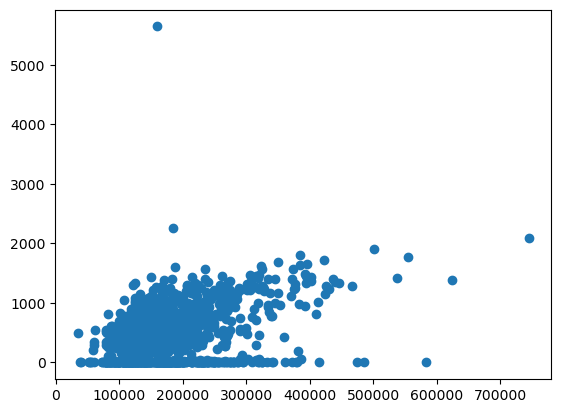

In [46]:
plt.scatter(x="SalePrice", y="BsmtFinSF1", data=train_data)

In [45]:
train_data.query("SalePrice > 500000")
#1182, 1298, 1169

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000


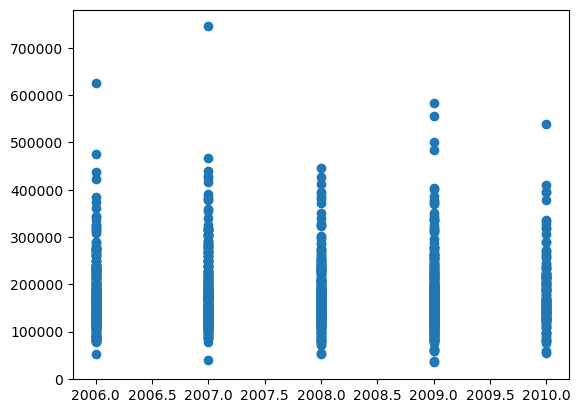

In [40]:
plt.scatter(x="YrSold", y="SalePrice", data=train_data)

MiscVal is a feature that represents the value of miscellaneous items in the house, such as a pool or a shed. It is not important and misleading feature, so we will drop it from the dataset. 



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("drop_columns", dropColumns(columns=["Id"])),
    ("log_transformer", LogTransformer()),
    ("age_calculator", AgeCalculator()),
    ("feature_imputer", FeatureImputer()),
])

train_data = pipeline.fit_transform(train_data)
val_data= pipeline.transform(val_data)
test_data = pipeline.transform(test_data)



<Axes: >

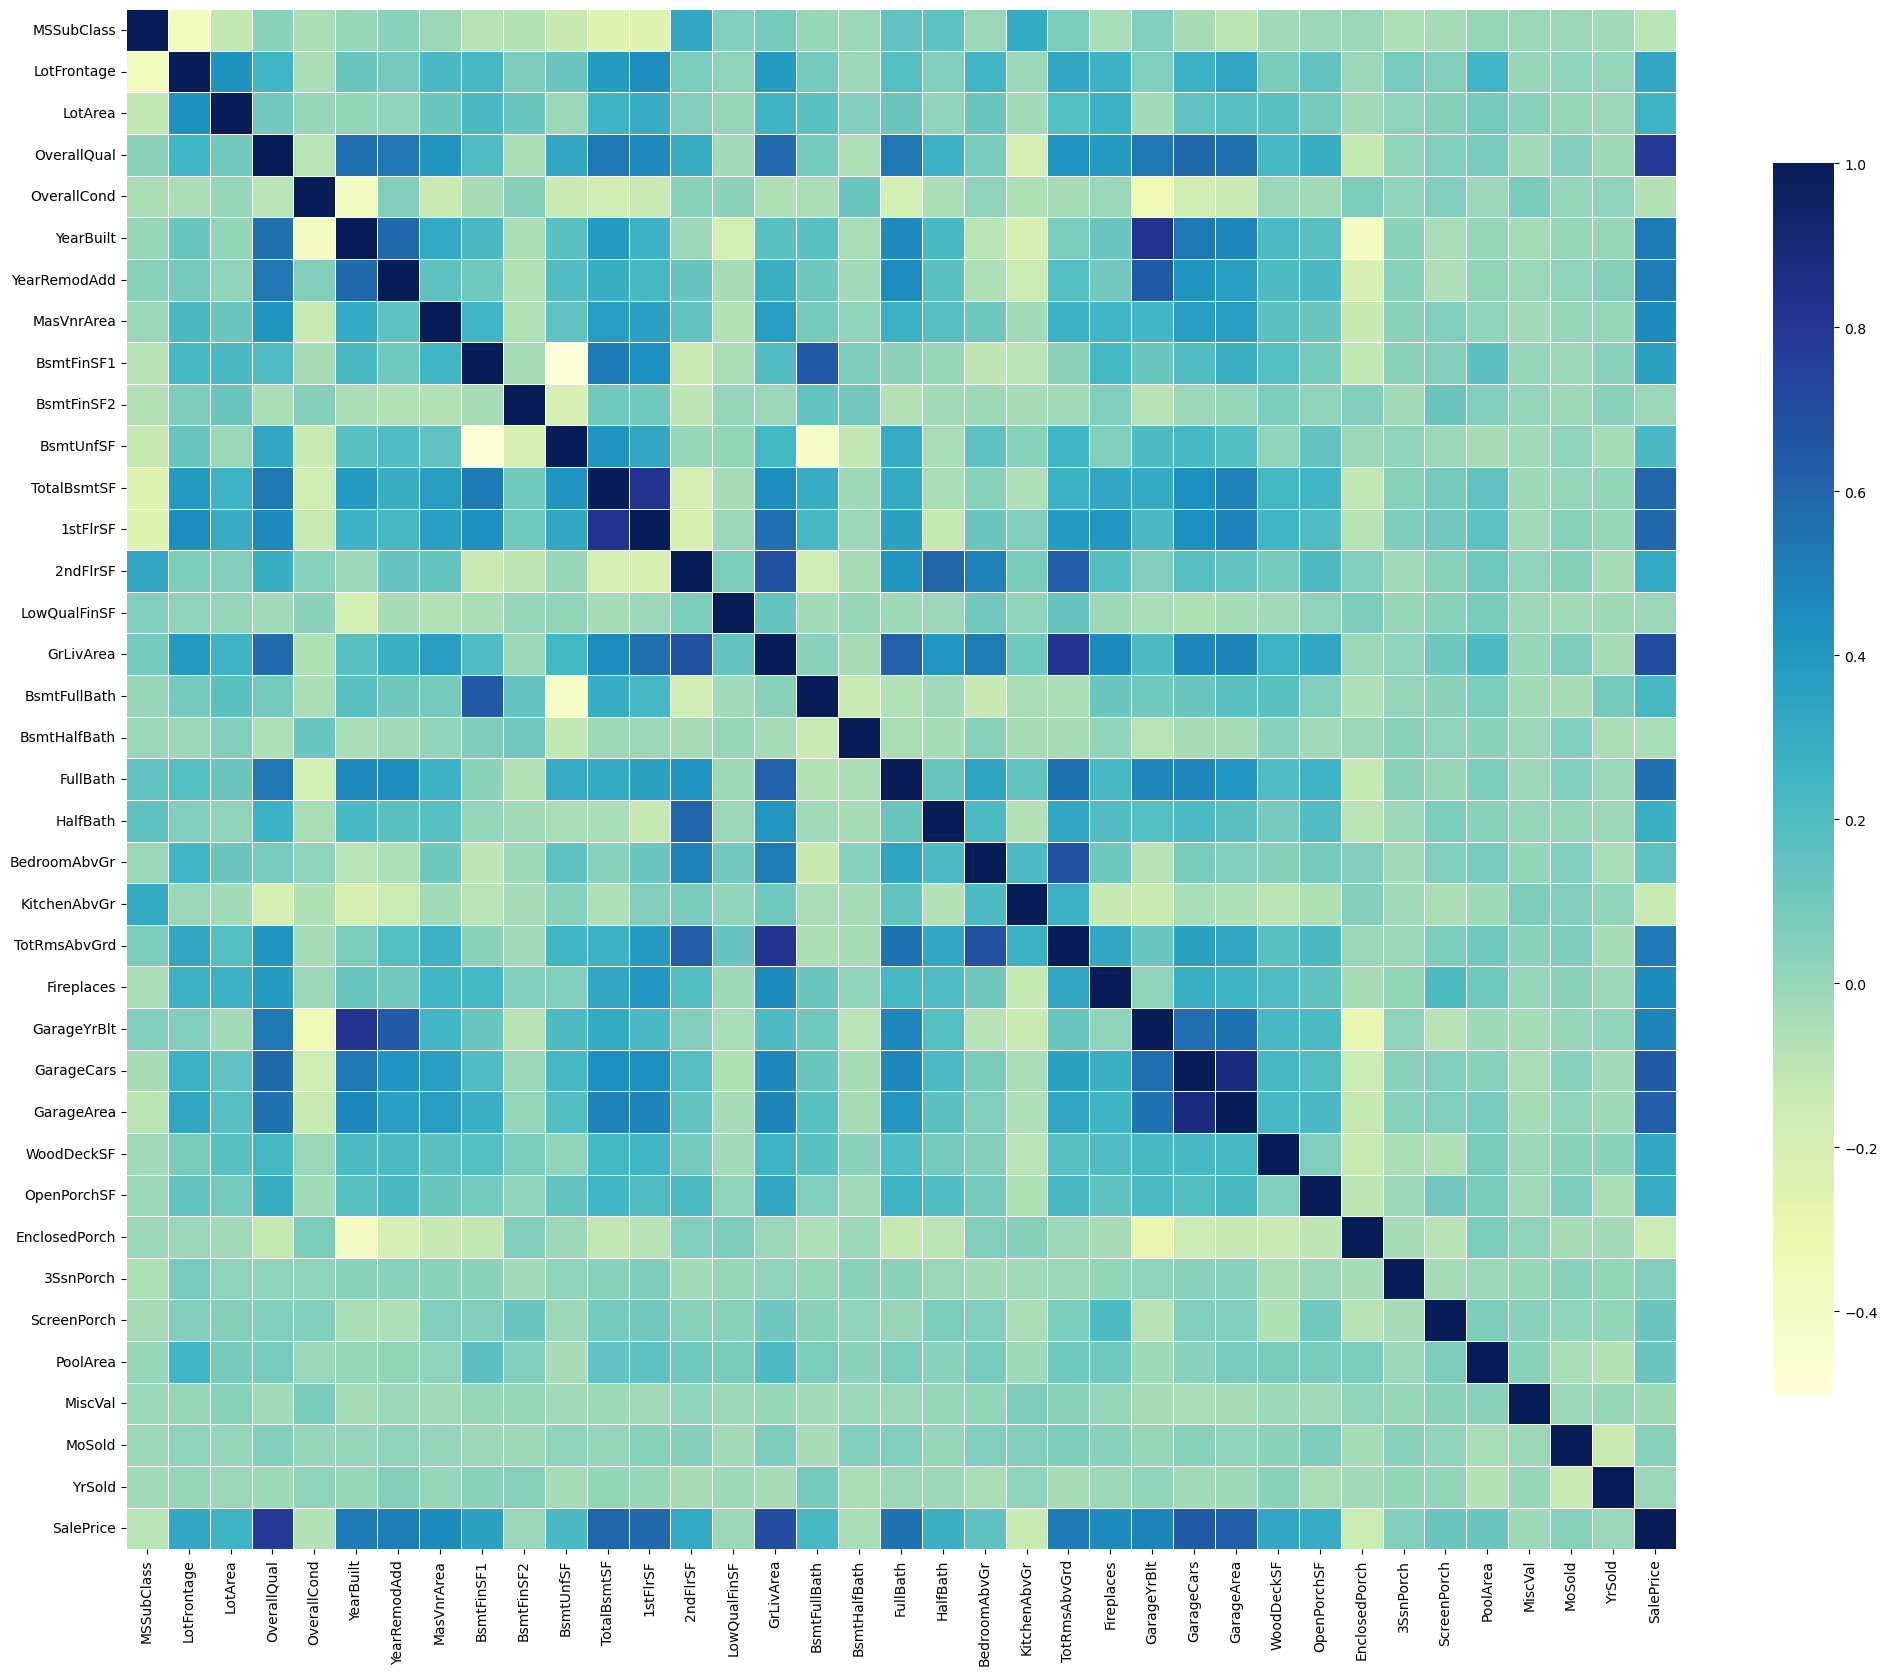

In [47]:
plt.figure(figsize=(25, 20))
sns.heatmap(numerical_values.corr(), fmt='.2f', cmap="YlGnBu", linewidths=0.5, cbar_kws={"shrink": .8})